# Анализ причинно-следственных связей по Грейнджеру: Температура и Демография/ДТП в Москве

Этот ноутбук реализует пайплайн для анализа причинно-следственных связей между временными рядами температуры и выбранным вторичным показателем (смертность или ДТП) для Москвы, используя тест Грейнджера.

## 1. Инициализация и Загрузка Библиотек

In [1]:
import sys
import os
import warnings

# Добавляем директорию src в путь Python
# Это необходимо, чтобы импортировать наши модули
if os.path.basename(os.getcwd()) != 'src':
    # Если ноутбук запускается из корня проекта
    if os.path.exists('src'):
        sys.path.append('src')
        print(f"Добавили 'src' в sys.path. Текущая директория: {os.getcwd()}")
    else:
        # Попытка подняться на уровень выше, если мы внутри src
        if os.path.exists('../src'):
             sys.path.append('..')
             print(f"Добавили '..' в sys.path. Текущая директория: {os.getcwd()}")
        else:
             print("Не удалось найти директорию 'src'. Убедитесь, что ноутбук находится в корне проекта или в 'src'.")
else:
    # Если ноутбук уже в src, добавляем родительскую директорию для доступа к data
    sys.path.append('..')
    print(f"Ноутбук в 'src'. Добавили '..' в sys.path.")

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown # Для красивого вывода в Jupyter

# Импорт модулей проекта
import config
from data_processing import loader, cleaner, merger
from analysis import stationarity, var_model, granger
from visualization import time_series, diagnostics
from utils import logger, helpers

# Настройки отображения
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore') # Подавляем предупреждения для чистоты вывода

# Настройка стиля графиков (из config)
try:
    plt.style.use(config.PLOT_STYLE)
except Exception as e:
    print(f"Не удалось применить стиль графиков из config: {e}. Используется стиль по умолчанию.")

# Настройка логирования (опционально для ноутбука)
# log = logger.setup_logger(use_file=False) # Вывод только в консоль
# log.info("Запуск анализа в Jupyter Notebook")
print("Библиотеки и модули успешно импортированы.")

Ноутбук в 'src'. Добавили '..' в sys.path.
Библиотеки и модули успешно импортированы.


## 2. Загрузка Конфигурации

Загружаем и отображаем основные параметры анализа из файла `config.py`.

In [2]:
display(Markdown("### Параметры Анализа:"))
print(f"Файл данных температуры: {config.TEMP_DATA_PATH}")
print(f"Файл вторичных данных: {config.SECONDARY_DATA_PATH}")
print(f"Название вторичных данных: {config.SECONDARY_DATA_NAME}")
print(f"Формат даты для агрегации: {config.DATE_FORMAT}")
print(f"Метод нормализации (Температура): {config.NORMALIZATION_METHOD_TEMP}")
print(f"Метод нормализации (Вторичные данные): {config.NORMALIZATION_METHOD_SECONDARY}")
print(f"Агрегация (Температура): {config.AGGREGATION_TEMP}")
print(f"Агрегация (Вторичные данные): {config.AGGREGATION_SECONDARY}")
print(f"Максимальный порядок дифференцирования: {config.MAX_DIFFERENCING_ORDER}")
print(f"Максимальный лаг для VAR: {config.MAX_LAG_ORDER}")
print(f"Критерии выбора лага: {config.LAG_SELECTION_CRITERIA}")
print(f"Уровень значимости (ADF): {config.ADF_SIGNIFICANCE_LEVEL}")
print(f"Уровень значимости (KPSS): {config.KPSS_SIGNIFICANCE_LEVEL}")
print(f"Уровень значимости (Granger): {config.GRANGER_SIGNIFICANCE_LEVEL}")
print(f"Интерактивные графики: {config.INTERACTIVE_PLOTS}")

### Параметры Анализа:

Файл данных температуры: ../data/Moscow_Temp (2010-2024).csv
Файл вторичных данных: ../data/Moscow/moscow_mortality.csv
Название вторичных данных: Mortality
Формат даты для агрегации: %Y-%m
Метод нормализации (Температура): z-score
Метод нормализации (Вторичные данные): log
Агрегация (Температура): mean
Агрегация (Вторичные данные): mean
Максимальный порядок дифференцирования: 2
Максимальный лаг для VAR: 12
Критерии выбора лага: ['aic', 'bic']
Уровень значимости (ADF): 0.05
Уровень значимости (KPSS): 0.05
Уровень значимости (Granger): 0.05
Интерактивные графики: True


## 3. Загрузка Данных

Загружаем исходные временные ряды температуры и выбранного вторичного показателя.

In [3]:
try:
    df_temp_raw, df_secondary_raw_loaded = loader.load_all_data(config.TEMP_DATA_PATH, config.SECONDARY_DATA_PATH)

    display(Markdown("### Исходные данные температуры (первые 5 строк):"))
    display(df_temp_raw.head())
    df_temp_raw.info()

    display(Markdown(f"### Исходные данные '{config.SECONDARY_DATA_NAME}' (первые 5 строк):"))
    display(df_secondary_raw_loaded.head())
    df_secondary_raw_loaded.info()

    # Make a copy to avoid modifying the original loaded data if needed elsewhere
    df_secondary_raw = df_secondary_raw_loaded.copy()

    # Specific preprocessing for DTP cumulative data
    if config.SECONDARY_DATA_NAME == "DTP":
        print(f"\nОбнаружен '{config.SECONDARY_DATA_NAME}'. Применяем специфическую предобработку для расчета месячных значений...")
        try:
            # --- DTP Monthly Calculation Logic ---
            dtp_original_col = config.SECONDARY_DATA_NAME # This should be 'DTP' based on your config
            date_col = 'Date' # Assuming loader provides a 'Date' column

            # 1. Убедимся, что колонка 'Date' является datetime и DataFrame сортирован
            if date_col not in df_secondary_raw.columns:
                 # Try to find the date column if loader didn't standardize it
                 potential_date_cols = [col for col in df_secondary_raw.columns if 'date' in col.lower() or 'дата' in col.lower()]
                 if not potential_date_cols:
                     raise ValueError("Could not automatically find the date column for DTP preprocessing.")
                 date_col = potential_date_cols[0]
                 print(f"Using '{date_col}' as the date column for DTP preprocessing.")

            if not pd.api.types.is_datetime64_any_dtype(df_secondary_raw[date_col]):
                 # Attempt to parse if loader didn't (adjust format if needed)
                 try:
                     df_secondary_raw[date_col] = pd.to_datetime(df_secondary_raw[date_col])
                 except ValueError:
                      # Try the specific format from the CSV header if parsing failed
                       try:
                           df_secondary_raw[date_col] = pd.to_datetime(df_secondary_raw[date_col], format='%m.%Y')
                       except Exception as parse_err:
                           raise ValueError(f"Could not parse date column '{date_col}' for DTP. Error: {parse_err}")

            df_secondary_raw = df_secondary_raw.sort_values(date_col)

            # 2. Calculate monthly difference
            monthly_col_name = f"{dtp_original_col}_Monthly"
            df_secondary_raw[monthly_col_name] = df_secondary_raw[dtp_original_col].diff()

            # 3. Correct the first month of each year (where diff is calculated relative to Dec of prev year)
            # Also handles the very first row of the dataset (where diff() yields NaN)
            year_start_mask = (df_secondary_raw[date_col].dt.month == 1) | (df_secondary_raw[monthly_col_name].isna())
            df_secondary_raw.loc[year_start_mask, monthly_col_name] = df_secondary_raw.loc[year_start_mask, dtp_original_col]

            # 4. Ensure the calculated monthly values are integers (or floats if necessary)
            df_secondary_raw[monthly_col_name] = df_secondary_raw[monthly_col_name].astype(int) # Or float if needed

            # 5. Prepare the dataframe for the next steps: Keep only Date and the new monthly column
            #    Rename the monthly column back to the original name expected by the config/pipeline
            df_secondary_raw = df_secondary_raw[[date_col, monthly_col_name]].rename(columns={monthly_col_name: dtp_original_col})
            # --- End of DTP Logic ---

            print("ДТП предпроцессинг завершен.")
            display(Markdown(f"#### Данные '{config.SECONDARY_DATA_NAME}' после расчета месячных значений (первые 15 строк):"))
            display(df_secondary_raw.head(15)) # Display more rows to see the change after year end
            df_secondary_raw.info()

        except KeyError as ke:
             print(f"Ошибка при предобработке ДТП: не найдена колонка {ke}. Убедитесь, что колонка '{dtp_original_col}' существует после загрузки.")
             raise
        except Exception as e:
            print(f"Ошибка во время специфической предобработки ДТП: {e}")
            raise
    else:
        print(f"\nDataset '{config.SECONDARY_DATA_NAME}' не требует специфической предобработки для расчета месячных значений.")
        # df_secondary_raw remains the originally loaded data for Mortality etc.


except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    # Прерываем выполнение или обрабатываем ошибку
    raise

Загрузка данных о температуре из: ../data/Moscow_Temp (2010-2024).csv
Данные о температуре успешно загружены.
Загрузка вторичных данных из: ../data/Moscow/moscow_mortality.csv
Данные о смертности успешно загружены.


### Исходные данные температуры (первые 5 строк):

,Date,Temperature,Precipitation
0,2010-01-01,-9.6,0.2
1,2010-01-02,-13.2,0.0
2,2010-01-03,-17.2,0.0
3,2010-01-04,-18.0,0.2
4,2010-01-05,-11.9,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5387 entries, 0 to 5386
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           5387 non-null   datetime64[ns]
 1   Temperature    5387 non-null   float64       
 2   Precipitation  5387 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 126.4 KB


### Исходные данные 'Mortality' (первые 5 строк):

,Date,Mortality
0,2010-01-01,10430
1,2010-02-01,9573
2,2010-03-01,10528
3,2010-04-01,9501
4,2010-05-01,9482


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       124 non-null    datetime64[ns]
 1   Mortality  124 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB

Dataset 'Mortality' не требует специфической предобработки для расчета месячных значений.


## 4. Предобработка Данных

Выполняем шаги предобработки:
1.  **Унификация временных меток:** Приведение дат к формату `YYYY-MM` и установка в качестве индекса.
2.  **Агрегация:** Расчет среднемесячной температуры и суммарных/средних значений для вторичного показателя.
3.  **Нормализация:** Применение Z-score стандартизации или логарифмирования.

### 4.1 Обработка данных температуры

In [4]:
# Важно: Укажите правильные имена колонок из ваших файлов!
# Имена колонок после обработки в loader.py
TEMP_DATE_COL = 'Date' 
TEMP_VALUE_COL = 'Temperature' 

try:
    # Шаг 1: Унификация временных меток
    # Убедитесь, что колонка TEMP_DATE_COL существует и содержит корректные даты
    df_temp_processed = cleaner.unify_timestamps(df_temp_raw.copy(), date_col=TEMP_DATE_COL, target_format=config.DATE_FORMAT)

    # Проверим, есть ли дубликаты в индексе
    if df_temp_processed.index.has_duplicates:
        print(f"Обнаружены дубликаты в индексе ({df_temp_processed.index.duplicated().sum()} штук). Агрегируем их...")
        # Группируем по индексу (по дате) и применяем агрегацию (например, 'mean')
        # Это создаст уникальный индекс перед месячной агрегацией.
        # Используйте нужную вам функцию агрегации (mean, median, sum, first, last и т.д.)
        df_temp_processed = df_temp_processed.groupby(level=0).mean() # level=0 означает группировку по индексу
        # Или, если вы хотите использовать ту же агрегацию, что и для месяца:
        # df_temp_processed = df_temp_processed.groupby(level=0).agg(config.AGGREGATION_TEMP)
        print("Дубликаты в индексе агрегированы.")

    # Шаг 2: Агрегация
    # Убедитесь, что колонка TEMP_VALUE_COL существует
    df_temp_agg = cleaner.aggregate_monthly(df_temp_processed, value_col=TEMP_VALUE_COL, agg_func=config.AGGREGATION_TEMP)

    # Шаг 3: Нормализация
    df_temp_norm = cleaner.normalize_data(df_temp_agg, method=config.NORMALIZATION_METHOD_TEMP)
    df_temp_norm.name = "Temperature_Norm"

    display(Markdown("#### Обработанные данные температуры (первые 5 строк):"))
    display(df_temp_norm.head())
    print(f"\nКоличество записей: {len(df_temp_norm)}")

except KeyError as e:
    print(f"Ошибка: Колонка {e} не найдена. Проверьте имена колонок TEMP_DATE_COL и TEMP_VALUE_COL.")
    raise
except Exception as e:
    print(f"Ошибка при обработке данных температуры: {e}")
    raise

Унификация временных меток для столбца: Date
Временные метки унифицированы и установлены в качестве индекса.
Обнаружены дубликаты в индексе (5210 штук). Агрегируем их...
Дубликаты в индексе агрегированы.
Агрегация столбца 'Temperature' помесячно с использованием 'mean'
Преобразование PeriodIndex в DatetimeIndex для агрегации.
Агрегация завершена.
Нормализация ряда с использованием метода: z-score


#### Обработанные данные температуры (первые 5 строк):

Month
2010-01-31   -2.188679
2010-02-28   -1.570865
2010-03-31   -0.826430
2010-04-30    0.131968
2010-05-31    0.986622
Freq: ME, Name: Temperature_Norm, dtype: float64


Количество записей: 177


### 4.2 Обработка вторичных данных

In [5]:
# Важно: Укажите правильные имена колонок из ваших файлов!
# Имена колонок после обработки в loader.py (для mortality.csv)
SECONDARY_DATE_COL = 'Date' 
SECONDARY_VALUE_COL = config.SECONDARY_DATA_NAME

try:
    # Шаг 1: Унификация временных меток
    df_secondary_processed = cleaner.unify_timestamps(df_secondary_raw.copy(), date_col=SECONDARY_DATE_COL, target_format=config.DATE_FORMAT)

    # Шаг 2: Агрегация
    df_secondary_agg = cleaner.aggregate_monthly(df_secondary_processed, value_col=SECONDARY_VALUE_COL, agg_func=config.AGGREGATION_SECONDARY)

    # Шаг 3: Нормализация
    df_secondary_norm = cleaner.normalize_data(df_secondary_agg, method=config.NORMALIZATION_METHOD_SECONDARY)
    df_secondary_norm.name = f"{config.SECONDARY_DATA_NAME}_Norm"

    display(Markdown(f"#### Обработанные данные '{config.SECONDARY_DATA_NAME}' (первые 5 строк):"))
    display(df_secondary_norm.head())
    print(f"\nКоличество записей: {len(df_secondary_norm)}")

except KeyError as e:
    print(f"Ошибка: Колонка {e} не найдена. Проверьте имена колонок SECONDARY_DATE_COL и SECONDARY_VALUE_COL.")
    raise
except Exception as e:
    print(f"Ошибка при обработке вторичных данных: {e}")
    raise

Унификация временных меток для столбца: Date
Временные метки унифицированы и установлены в качестве индекса.
Агрегация столбца 'Mortality' помесячно с использованием 'mean'
Преобразование PeriodIndex в DatetimeIndex для агрегации.
Агрегация завершена.
Нормализация ряда с использованием метода: log


#### Обработанные данные 'Mortality' (первые 5 строк):

Month
2010-01-31    9.252442
2010-02-28    9.166702
2010-03-31    9.261794
2010-04-30    9.159152
2010-05-31    9.157151
Freq: ME, Name: Mortality_Norm, dtype: float64


Количество записей: 124


### 4.3 Объединение данных

Объединяем обработанные ряды в один DataFrame, используя внутреннее соединение (`inner`) для сохранения только пересекающихся временных периодов.

In [6]:
try:
    df_merged = merger.merge_dataframes(df_temp_norm.to_frame(), df_secondary_norm.to_frame(), how='inner')

    display(Markdown("#### Объединенные данные (первые 5 строк):"))
    display(df_merged.head())
    print(f"\nИтоговое количество записей: {len(df_merged)}")
    print(f"Временной диапазон: {df_merged.index.min()} - {df_merged.index.max()}")

    # Проверка на пропуски после объединения
    merger.check_completeness(df_merged)

except Exception as e:
    print(f"Ошибка при объединении данных: {e}")
    raise

Объединение датафреймов с использованием метода: inner
DataFrame успешно объединены.


#### Объединенные данные (первые 5 строк):

,Temperature_Norm,Mortality_Norm
Month,,
2010-01-31,-2.188679,9.252442
2010-02-28,-1.570865,9.166702
2010-03-31,-0.826430,9.261794
2010-04-30,0.131968,9.159152
2010-05-31,0.986622,9.157151



Итоговое количество записей: 124
Временной диапазон: 2010-01-31 00:00:00 - 2020-04-30 00:00:00
Проверка полноты объединенных данных...
Пропущенные значения не обнаружены.
Индекс временного ряда непрерывный (нет пропусков).


## 5. Визуализация Обработанных Рядов

Строим графики объединенных и нормализованных временных рядов.

In [7]:
if config.INTERACTIVE_PLOTS:
    try:
        time_series.plot_time_series_interactive(df_merged, title="Обработанные и объединенные временные ряды (Интерактивно)")
    except Exception as e:
        print(f"Ошибка при построении интерактивного графика: {e}. Попробуем статический график.")
        time_series.plot_time_series(df_merged, title="Обработанные и объединенные временные ряды")
else:
    time_series.plot_time_series(df_merged, title="Обработанные и объединенные временные ряды")

Запрошено интерактивное построение графиков (требуется Plotly).


## 6. Проверка Стационарности

Проверяем ряды на стационарность с помощью тестов ADF (Augmented Dickey-Fuller) и KPSS (Kwiatkowski-Phillips-Schmidt-Shin).

-   **ADF Тест:**
    -   H0: Ряд имеет единичный корень (нестационарен).
    -   H1: Ряд не имеет единичного корня (стационарен).
    -   *Ожидание:* p-value < уровня значимости (например, 0.05) для отклонения H0.
-   **KPSS Тест:**
    -   H0: Ряд стационарен относительно уровня или тренда.
    -   H1: Ряд имеет единичный корень (нестационарен).
    -   *Ожидание:* p-value >= уровня значимости (например, 0.05) для НЕотклонения H0.

Если ряды нестационарны, применяем дифференцирование и повторяем проверку.

In [8]:
display(Markdown("### Проверка стационарности исходных (объединенных) рядов:"))
stationarity_results_orig = stationarity.check_stationarity_on_dataframe(
    df_merged, 
    adf_level=config.ADF_SIGNIFICANCE_LEVEL, 
    kpss_level=config.KPSS_SIGNIFICANCE_LEVEL
)

# Анализ результатов и принятие решения о дифференцировании
needs_differencing = False
for col, results in stationarity_results_orig.items():
    # Считаем ряд нестационарным, если ADF не отвергает H0 ИЛИ KPSS отвергает H0
    if not results['ADF'][0] or not results['KPSS'][0]:
        needs_differencing = True
        print(f"\nРяд '{col}' вероятно нестационарен. Рекомендуется дифференцирование.")
        break # Достаточно одного нестационарного ряда для дифференцирования всего датафрейма

if needs_differencing:
    diff_order = 1 # Начинаем с первого порядка
    print(f"\nПрименяем дифференцирование порядка {diff_order}...")
    df_stationary = stationarity.apply_differencing(df_merged, order=diff_order)
    
    display(Markdown(f"### Проверка стационарности после дифференцирования (порядок {diff_order}):"))
    stationarity_results_diff = stationarity.check_stationarity_on_dataframe(
        df_stationary, 
        adf_level=config.ADF_SIGNIFICANCE_LEVEL, 
        kpss_level=config.KPSS_SIGNIFICANCE_LEVEL
    )
    # TODO: Добавить логику для повторного дифференцирования (order=2), если необходимо
    # Проверяем стационарность df_stationary и при необходимости применяем diff(2)
    still_needs_diff = False
    for col, results in stationarity_results_diff.items():
        if not results['ADF'][0] or not results['KPSS'][0]:
             still_needs_diff = True
             print(f"\nРяд '{col}' все еще может быть нестационарен после diff(1).")
             break
    if still_needs_diff and config.MAX_DIFFERENCING_ORDER >= 2:
         diff_order = 2
         print(f"\nПрименяем дифференцирование порядка {diff_order}...")
         # Применяем к исходному df_merged, а не к df_stationary
         df_stationary = stationarity.apply_differencing(df_merged, order=diff_order)
         display(Markdown(f"### Проверка стационарности после дифференцирования (порядок {diff_order}):"))
         stationarity.check_stationarity_on_dataframe(df_stationary, adf_level=config.ADF_SIGNIFICANCE_LEVEL, kpss_level=config.KPSS_SIGNIFICANCE_LEVEL)
    elif still_needs_diff:
         print(f"\nПредупреждение: Ряды могут быть нестационарны даже после дифференцирования максимального порядка ({config.MAX_DIFFERENCING_ORDER}). Результаты VAR/Granger могут быть ненадежными.")
else:
    print("\nВсе ряды стационарны. Дифференцирование не требуется.")
    df_stationary = df_merged.copy() # Используем исходные данные

display(Markdown("#### Итоговые данные для моделирования (первые 5 строк):"))
display(df_stationary.head())

### Проверка стационарности исходных (объединенных) рядов:


--- Проверка стационарности для: Temperature_Norm ---
Выполнение ADF теста для ряда: Temperature_Norm (Регрессия: c)
Результаты ADF теста для Temperature_Norm:
  Статистика теста: -1.7241
  P-значение: 0.4187
  Использовано лагов: 12
  Стационарность (p < 0.05): False
Выполнение KPSS теста для ряда: Temperature_Norm (Регрессия: c)
Результаты KPSS теста для Temperature_Norm:
  Статистика теста: 0.0159
  P-значение: 0.1000 (Примечание: p-значения интерполированы и могут быть ограничены 0.01илиr 0.1)
  Использовано лагов: 5
  Стационарность (p >= 0.05): True

--- Проверка стационарности для: Mortality_Norm ---
Выполнение ADF теста для ряда: Mortality_Norm (Регрессия: c)
Результаты ADF теста для Mortality_Norm:
  Статистика теста: -1.7729
  P-значение: 0.3940
  Использовано лагов: 13
  Стационарность (p < 0.05): False
Выполнение KPSS теста для ряда: Mortality_Norm (Регрессия: c)
Результаты KPSS теста для Mortality_Norm:
  Статистика теста: 0.3510
  P-значение: 0.0983 (Примечание: p-значен

### Проверка стационарности после дифференцирования (порядок 1):


--- Проверка стационарности для: Temperature_Norm ---
Выполнение ADF теста для ряда: Temperature_Norm (Регрессия: c)
Результаты ADF теста для Temperature_Norm:
  Статистика теста: -9.3855
  P-значение: 0.0000
  Использовано лагов: 11
  Стационарность (p < 0.05): True
Выполнение KPSS теста для ряда: Temperature_Norm (Регрессия: c)
Результаты KPSS теста для Temperature_Norm:
  Статистика теста: 0.0329
  P-значение: 0.1000 (Примечание: p-значения интерполированы и могут быть ограничены 0.01илиr 0.1)
  Использовано лагов: 5
  Стационарность (p >= 0.05): True

--- Проверка стационарности для: Mortality_Norm ---
Выполнение ADF теста для ряда: Mortality_Norm (Регрессия: c)
Результаты ADF теста для Mortality_Norm:
  Статистика теста: -5.0238
  P-значение: 0.0000
  Использовано лагов: 12
  Стационарность (p < 0.05): True
Выполнение KPSS теста для ряда: Mortality_Norm (Регрессия: c)
Результаты KPSS теста для Mortality_Norm:
  Статистика теста: 0.2325
  P-значение: 0.1000 (Примечание: p-значения

#### Итоговые данные для моделирования (первые 5 строк):

,Temperature_Norm,Mortality_Norm
Month,,
2010-02-28,0.617814,-0.085740
2010-03-31,0.744435,0.095092
2010-04-30,0.958397,-0.102641
2010-05-31,0.854654,-0.002002
2010-06-30,0.207870,0.004945


## 7. Визуализация Стационарных Рядов и ACF/PACF

Строим графики рядов после преобразований (если они применялись) и их автокорреляционные (ACF) и частично автокорреляционные (PACF) функции для визуальной оценки структуры зависимостей.

### Графики стационарных рядов:

Запрошено интерактивное построение графиков (требуется Plotly).


### Графики ACF/PACF для стационарных рядов:

Отображение ACF/PACF для: Temperature_Norm


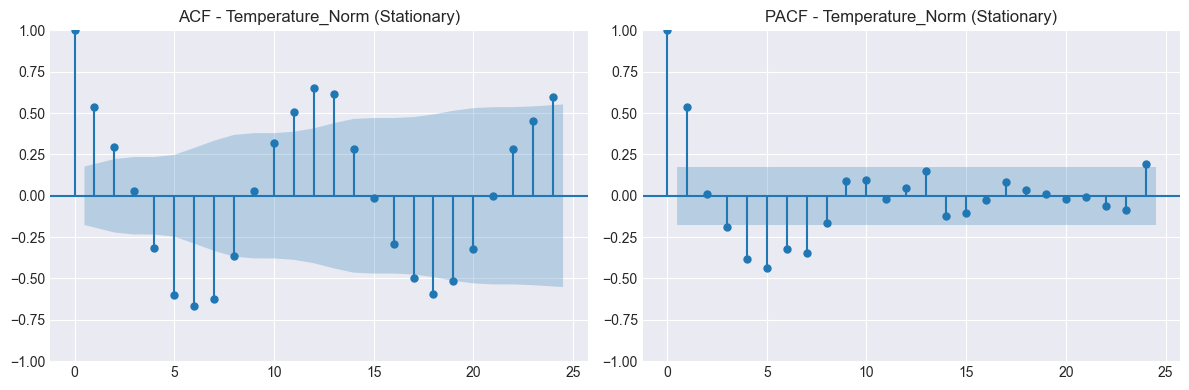

Отображение ACF/PACF для: Mortality_Norm


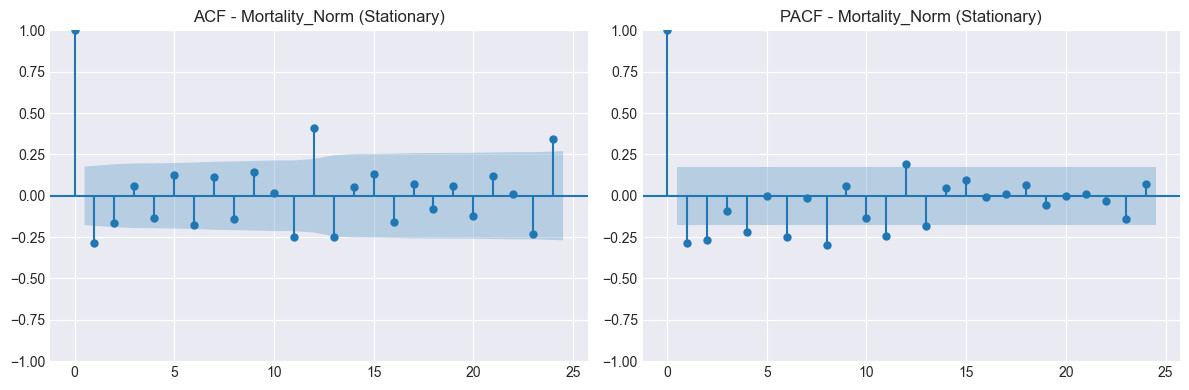

In [9]:
display(Markdown("### Графики стационарных рядов:"))
if config.INTERACTIVE_PLOTS:
    try:
        time_series.plot_time_series_interactive(df_stationary, title="Стационарные временные ряды (Интерактивно)")
    except Exception as e:
        print(f"Ошибка при построении интерактивного графика: {e}. Попробуем статический график.")
        time_series.plot_time_series(df_stationary, title="Стационарные временные ряды")
else:
    time_series.plot_time_series(df_stationary, title="Стационарные временные ряды")

display(Markdown("### Графики ACF/PACF для стационарных рядов:"))
acf_pacf_lags = 24 # Количество лагов для отображения
for col in df_stationary.columns:
    time_series.plot_acf_pacf(df_stationary[col], lags=acf_pacf_lags, title_suffix="(Stationary)")

## 8. Определение Оптимального Лага VAR Модели

Подбираем оптимальный порядок лага для модели векторной авторегрессии (VAR), используя информационные критерии (AIC, BIC и др.). Модель VAR описывает каждый временной ряд как линейную функцию от его собственных прошлых значений и прошлых значений других рядов в системе.

In [10]:
try:
    optimal_lags = var_model.select_optimal_lag(
        df_stationary, 
        max_lags=config.MAX_LAG_ORDER, 
        criteria=config.LAG_SELECTION_CRITERIA
    )
    
    # Выбор лага (например, по BIC, который обычно выбирает более парсимоничные модели)
    chosen_lag = optimal_lags.get('bic', -1)
    if chosen_lag == -1: # Если BIC не найден, пробуем AIC
        chosen_lag = optimal_lags.get('aic', -1)
        if chosen_lag != -1:
             print("\nBIC не найден, используем лаг по AIC.")
    
    if chosen_lag <= 0:
        print(f"\nПредупреждение: Оптимальный лаг ({chosen_lag}) не является положительным числом. VAR модель не может быть построена. Проверьте данные или увеличьте max_lags.")
        # Можно попробовать установить лаг вручную, например, 1, но это может быть некорректно
        # chosen_lag = 1 
        # print("Устанавливаем лаг = 1 вручную для продолжения анализа (результаты могут быть неточными).")
    else:
        print(f"\nВыбранный оптимальный лаг для VAR модели: {chosen_lag}")

except Exception as e:
    print(f"Ошибка при выборе оптимального лага: {e}")
    chosen_lag = -1 # Устанавливаем невалидный лаг при ошибке
    raise

Выбор оптимального порядка лагов (max_lags=12) по критериям: ['aic', 'bic']

Lag Selection Results Summary:
Результаты выбора порядка лагов:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.284      -6.235    0.001866      -6.264
1       -6.927      -6.780   0.0009813      -6.867
2       -7.191      -6.947   0.0007533      -7.092
3       -7.211      -6.869   0.0007390      -7.072
4       -7.389      -6.950   0.0006184      -7.211
5       -7.562      -7.025   0.0005207      -7.344
6       -7.706      -7.072   0.0004509      -7.449
7       -7.923      -7.190   0.0003636      -7.626
8       -8.170      -7.340   0.0002845      -7.833
9       -8.250      -7.323   0.0002630      -7.874
10      -8.247      -7.222   0.0002644      -7.831
11      -8.423      -7.300   0.0002225      -7.967
12     -8.587*     -7.366*  0.0001895*     -8.092*
-------------------------------------------

## 9. Построение и Проверка VAR Модели

Строим VAR модель с выбранным оптимальным лагом и проверяем ее стабильность. Стабильность означает, что модель не будет генерировать взрывных прогнозов и является условием для корректной интерпретации импульсных откликов и результатов теста Грейнджера.

In [11]:
var_results = None
is_stable = False

if chosen_lag > 0:
    try:
        var_results = var_model.fit_var_model(df_stationary, lag_order=chosen_lag)
        if var_results:
            is_stable = var_model.check_model_stability(var_results)
            if not is_stable:
                print("\nПредупреждение: VAR модель нестабильна! Результаты теста Грейнджера и IRF могут быть некорректными.")
                print("Возможные причины: неправильный выбор лага, нестационарность данных (несмотря на тесты), структурные сдвиги.")
        else:
            print("Не удалось построить VAR модель.")
    except Exception as e:
        print(f"Ошибка при построении или проверке VAR модели: {e}")
else:
    print("Оптимальный лаг не выбран или некорректен, построение VAR модели пропускается.")

Подгонка VAR модели с порядком лагов: 12

Результаты подгонки VAR модели:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Apr, 2025
Time:                     12:21:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.36640
Nobs:                     111.000    HQIC:                  -8.09178
Log likelihood:           211.569    FPE:                0.000189486
AIC:                     -8.58691    Det(Omega_mle):     0.000126225
--------------------------------------------------------------------
Results for equation Temperature_Norm
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.009659         0.024040            0.402           0.688
L1.Temperature_Norm         -0.6234

## 10. Тест Грейнджера на Причинно-Следственную Связь

Проводим тест Грейнджера, чтобы определить, помогает ли знание прошлых значений одного временного ряда предсказывать будущие значения другого ряда.

Формулировка гипотез (для `X -> Y`):
-   **H0:** Прошлые значения X **не** помогают предсказывать Y (X не является причиной Y по Грейнджеру).
-   **H1:** Прошлые значения X **помогают** предсказывать Y (X является причиной Y по Грейнджеру).

Мы ищем низкие p-value (меньше уровня значимости, например, 0.05), чтобы отвергнуть H0 и сделать вывод о наличии причинности по Грейнджеру.

In [12]:
granger_summary = None
if var_results:
    try:
        # Используем лаг, с которым была построена модель VAR
        granger_lag = var_results.k_ar 
        granger_results_dict = granger.perform_granger_causality_test(
            var_results, 
            max_lag=granger_lag, 
            significance_level=config.GRANGER_SIGNIFICANCE_LEVEL
        )
        
        if granger_results_dict:
            granger_summary = granger.summarize_granger_results(granger_results_dict)
            display(Markdown("### Результаты теста Грейнджера:"))
            display(granger_summary)
        else:
            print("Не удалось получить результаты теста Грейнджера.")

    except Exception as e:
        print(f"Ошибка при выполнении теста Грейнджера: {e}")
else:
    print("VAR модель не была успешно построена, тест Грейнджера пропускается.")


Выполнение тестов причинности Грейнджера (max_lag=12, alpha=0.05)...
  Тест: Mortality_Norm вызывает Temperature_Norm по Грейнджеру?
    ssr_ftest: p-значение=0.2296 (Не значимо)
    params_ftest: p-значение=0.2296 (Не значимо)
  Тест: Temperature_Norm вызывает Mortality_Norm по Грейнджеру?
    ssr_ftest: p-значение=0.0001 (Значимо)
    params_ftest: p-значение=0.0001 (Значимо)


### Результаты теста Грейнджера:

,Effect,Lag,SSR_p_value,SSR_Significant,Params_p_value,Params_Significant,Details
0,Mortality_Norm -> Temperature_Norm,12,0.2296,False,0.2296,False,"F=1.31, df=(86, 12)"
1,Temperature_Norm -> Mortality_Norm,12,0.0001,True,0.0001,True,"F=3.89, df=(86, 12)"


## 11. Визуализация Диагностик Модели

Строим диагностические графики для анализа динамики взаимодействия между переменными:

-   **Импульсные Отклики (Impulse Response Functions - IRF):** Показывают реакцию одной переменной на шок (неожиданное изменение) в другой переменной на протяжении нескольких периодов времени.
-   **Декомпозиция Дисперсии Ошибок Прогноза (Forecast Error Variance Decomposition - FEVD):** Показывает, какая доля дисперсии ошибки прогноза каждой переменной объясняется шоками в других переменных (включая саму себя) на разных горизонтах прогнозирования.

### Графики Импульсных Откликов (IRF):

Построение графиков функций импульсной характеристики (периоды: 24)...
  Построение графиков всех IRF.


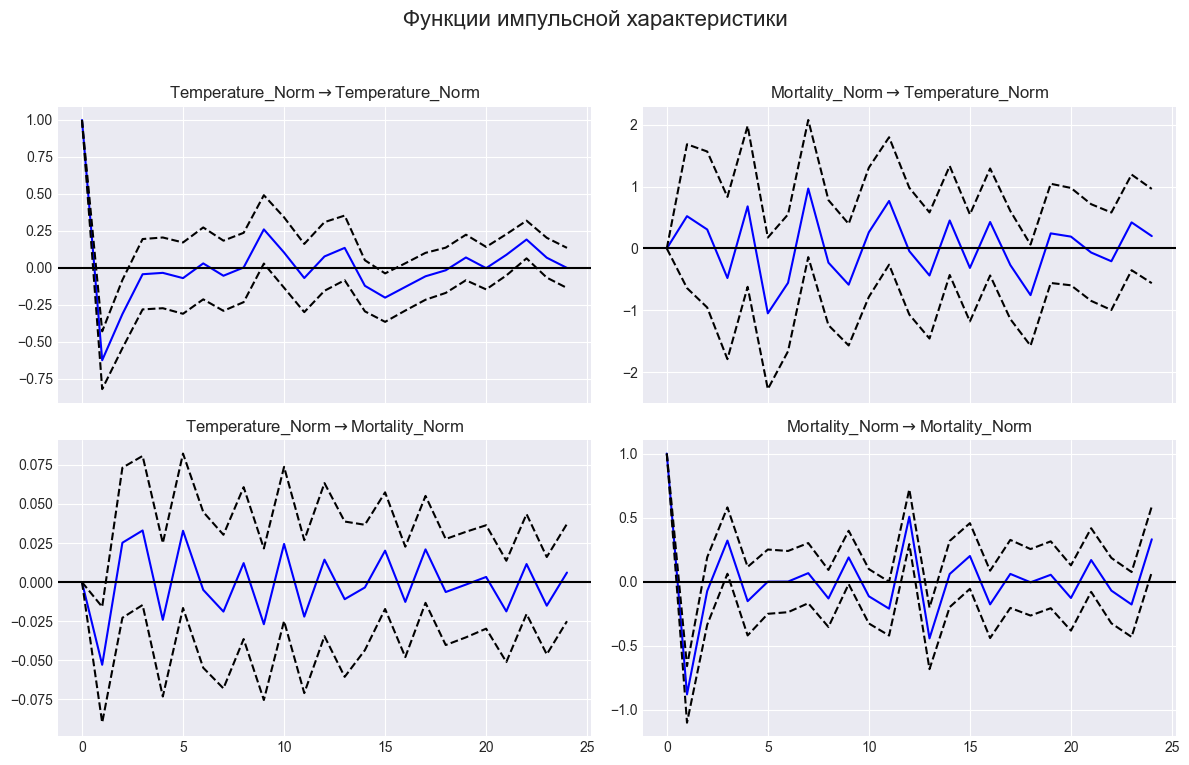

### Графики Декомпозиции Дисперсии Ошибок Прогноза (FEVD):

Вычисление и построение графика FEVD (Тип: bar, Периоды: 24)...
FEVD for Temperature_Norm
      Temperature_Norm  Mortality_Norm
0             1.000000        0.000000
1             0.993792        0.006208
2             0.992252        0.007748
3             0.987502        0.012498
4             0.978047        0.021953
5             0.956261        0.043739
6             0.950451        0.049549
7             0.933338        0.066662
8             0.932389        0.067611
9             0.929811        0.070189
10            0.928947        0.071053
11            0.919551        0.080449
12            0.919807        0.080193
13            0.917838        0.082162
14            0.915506        0.084494
15            0.915429        0.084571
16            0.913621        0.086379
17            0.912598        0.087402
18            0.904016        0.095984
19            0.903280        0.096720
20            0.902736        0.097264
21            0.903094        0.096906
22           

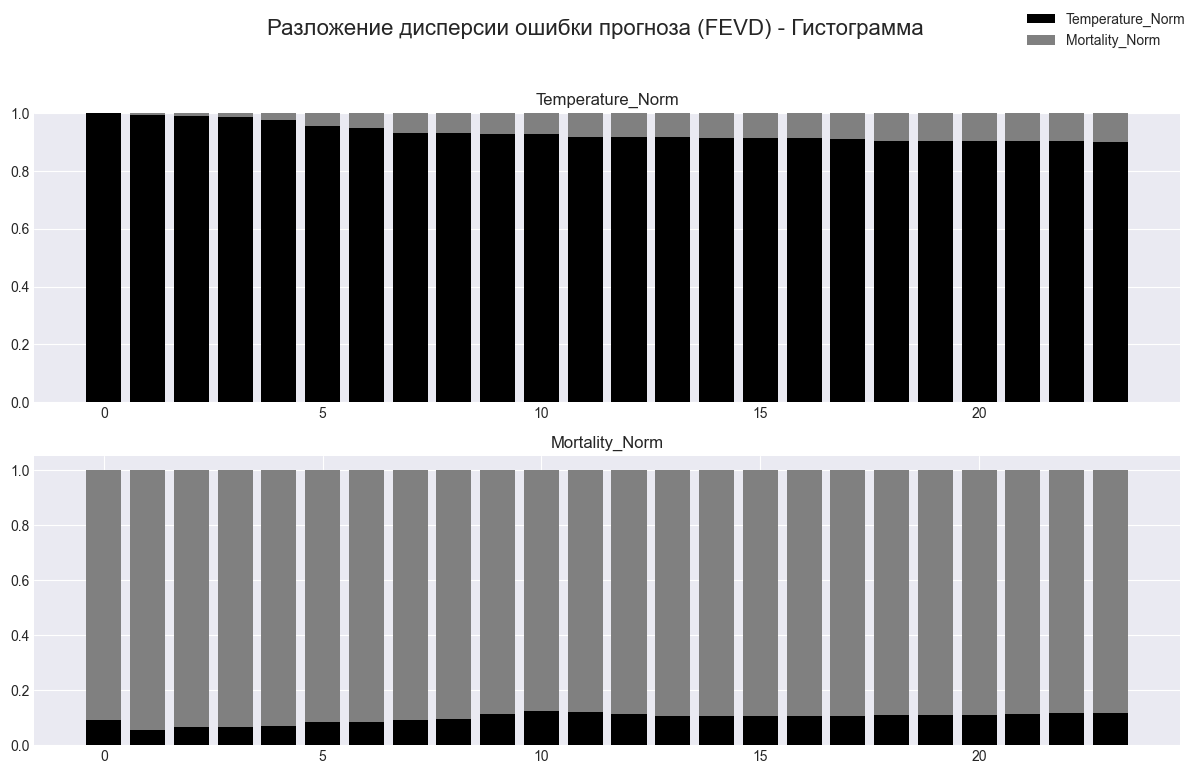

In [13]:
if var_results:
    plot_periods = 24 # Горизонт для IRF и FEVD
    display(Markdown("### Графики Импульсных Откликов (IRF):"))
    try:
        diagnostics.plot_impulse_response(var_results, periods=plot_periods)
    except Exception as e:
        print(f"Ошибка при построении IRF: {e}")
    
    display(Markdown("### Графики Декомпозиции Дисперсии Ошибок Прогноза (FEVD):"))
    try:
        diagnostics.plot_fevd(var_results, periods=plot_periods)
    except Exception as e:
        print(f"Ошибка при построении FEVD: {e}")
else:
    print("VAR модель не была успешно построена, диагностические графики пропускаются.")

**1. Верхний график (Заголовок: Temperature_Norm):**

*   **Что показывает:** Этот график анализирует **дисперсию ошибки прогноза для переменной `Temperature_Norm`**.
*   **Ось X:** Горизонт прогнозирования (количество шагов/месяцев вперед, от 0 до ~24).
*   **Ось Y:** Доля дисперсии (от 0 до 1, или 0% до 100%).
*   **Столбцы:** Каждый столбец соответствует определенному горизонту прогноза. Высота каждого столбца всегда равна 1 (100%).
*   **Цвета в столбцах:**
    *   **Черный (Temperature_Norm):** Показывает, какая доля ошибки прогноза температуры на данном горизонте объясняется *собственными* неожиданными шоками (изменениями) температуры в прошлом.
    *   **Серый (Mortality_Norm):** Показывает, какая доля ошибки прогноза температуры на данном горизонте объясняется неожиданными шоками *смертности* в прошлом.
*   **Интерпретация:** Мы видим, что **практически вся высота каждого столбца (почти 100%) занята черным цветом** на всех горизонтах прогноза. Серый сегмент очень мал. Это означает, что **неопределенность в прогнозе будущей температуры почти полностью объясняется её собственной прошлой динамикой и случайными колебаниями.** Шок (неожиданное изменение) в смертности практически не вносит вклада в ошибку прогноза температуры в рамках этой модели. Температура ведет себя как экзогенная переменная по отношению к смертности.

**2. Нижний график (Заголовок: Mortality_Norm):**

*   **Что показывает:** Этот график анализирует **дисперсию ошибки прогноза для переменной `Mortality_Norm`**.
*   **Оси X и Y:** Аналогичны верхнему графику.
*   **Цвета в столбцах:**
    *   **Черный (Temperature_Norm):** Показывает, какая доля ошибки прогноза смертности на данном горизонте объясняется неожиданными шоками *температуры* в прошлом.
    *   **Серый (Mortality_Norm):** Показывает, какая доля ошибки прогноза смертности на данном горизонте объясняется *собственными* неожиданными шоками смертности в прошлом.
*   **Интерпретация:** Здесь мы видим другую картину. **Основная часть каждого столбца (около 90-95%) занята серым цветом**, что означает, что большая часть неопределенности в прогнозе смертности объясняется её собственной прошлой динамикой. Однако, **присутствует небольшой, но заметный черный сегмент (около 5-10%)**, который остается относительно стабильным на разных горизонтах прогноза. Это говорит о том, что **неожиданные шоки температуры вносят небольшой, но постоянный вклад в ошибку прогноза смертности.**

**Общий вывод из графика:**
*   Температура в данной модели в значительной степени независима от прошлых шоков смертности.
*   Смертность в основном определяется своей собственной историей, но прошлые неожиданные изменения температуры оказывают некоторое (хоть и небольшое) влияние на предсказуемость будущей смертности. Это может указывать на слабую причинно-следственную связь по Грейнджеру от температуры к смертности, но не наоборот.

# 12. Выводы и Интерпретация

## Выводы по Смертность и Температура (Temperature -> Mortality)

На основе проведенного анализа причинно-следственных связей по Грейнджеру между среднемесячной температурой и ежемесячной смертностью в Москве (с января 2010 по апрель 2020), можно сделать следующие выводы:

1.  **Стационарность:**
    *   Исходные временные ряды (после нормализации: z-score для температуры, log для смертности) оказались **нестационарными** по результатам тестов ADF и KPSS.
    *   Для достижения стационарности потребовалось применить **дифференцирование первого порядка (d=1)**. После этой операции оба ряда стали стационарными, что является необходимым условием для корректного применения VAR-модели и теста Грейнджера.

2.  **VAR Модель:**
    *   На основе информационных критериев AIC и BIC был выбран **оптимальный лаг p=12** для модели векторной авторегрессии (VAR). Такой высокий порядок лага для месячных данных может указывать на наличие значимых сезонных (годовых) зависимостей или долгосрочных эффектов в динамике температуры и смертности.
    *   Построенная модель VAR(12) прошла проверку на **стабильность**. Это означает, что модель адекватна и не будет генерировать "взрывных" прогнозов, а результаты теста Грейнджера, импульсных откликов (IRF) и декомпозиции дисперсии (FEVD) являются интерпретируемыми.

3.  **Причинность по Грейнджеру (Уровень значимости α = 0.05):**
    *   **Влияние Температуры на Смертность (Temperature\_Norm -> Mortality\_Norm):**
        *   **Результат:** p-value = 0.0001 (меньше 0.05).
        *   **Интерпретация:** Нулевая гипотеза (H0: "Температура НЕ является причиной смертности по Грейнджеру") **отвергается**. Это означает, что прошлые значения температуры (за период до 12 месяцев назад) содержат статистически значимую информацию, которая помогает предсказывать будущие значения смертности, помимо той информации, которая уже содержится в прошлых значениях самой смертности.
    *   **Влияние Смертности на Температуру (Mortality\_Norm -> Temperature\_Norm):**
        *   **Результат:** p-value = 0.2296 (больше 0.05).
        *   **Интерпретация:** Нулевая гипотеза (H0: "Смертность НЕ является причиной температуры по Грейнджеру") **не отвергается**. Это означает, что прошлые значения смертности не предоставляют статистически значимой дополнительной информации для предсказания будущих значений температуры.
    *   **Вывод по причинности:** Обнаружена **однонаправленная причинно-следственная связь по Грейнджеру**, идущая от температуры к смертности. Обратная связь статистически не значима.

4.  **IRF и FEVD (Интерпретация на основе стабильности модели и результатов Грейнджера):**
    *   **Импульсные Отклики (IRF):** Поскольку модель стабильна и обнаружена связь Temp -> Mort, график IRF должен показывать статистически значимую реакцию (положительную или отрицательную, в зависимости от знака коэффициентов и лага) показателя смертности на неожиданное изменение (шок) в температуре в прошлых периодах. Реакция температуры на шок в смертности, скорее всего, будет незначимой (доверительный интервал включает ноль). Для детального анализа формы и длительности реакции нужно смотреть сами графики IRF.
    *   **Декомпозиция Дисперсии (FEVD):** График FEVD для смертности должен показать, что доля дисперсии ошибки прогноза, объясняемая шоками температуры, вероятно, увеличивается с увеличением горизонта прогнозирования и становится заметной. В то же время, для температуры доля дисперсии, объясняемая шоками смертности, должна оставаться низкой на всех горизонтах.

5.  **Общий вывод:**
    Анализ предоставляет статистические доказательства в пользу гипотезы о том, что **изменения среднемесячной температуры в Москве в прошлом влияют на последующие изменения уровня ежемесячной смертности** в период с 2010 по 2020 год, в контексте предсказательной способности по Грейнджеру. Противоположное влияние (смертности на температуру) статистически не подтверждается, что соответствует логике изучаемых явлений. Этот результат подчеркивает важность температурных факторов для общественного здоровья и демографических показателей в городе.

**Как читать результаты:**

*   **Стационарность:** Важно убедиться, что ряды стационарны (или приведены к стационарности) перед тестом Грейнджера. Если нет - результаты ненадежны.
*   **VAR лаг (p):** Показывает, сколько прошлых периодов учитывается в модели. Лаг 12 означает учет годовой истории.
*   **Стабильность VAR:** Если модель стабильна, тест Грейнджера и IRF/FEVD корректны. Если нет - выводы делать нельзя.
*   **P-value (тест Грейнджера):** Если p-value < 0.05 (или выбранного уровня значимости), отвергаем H0 и заключаем, что "X является причиной Y по Грейнджеру". Если p-value >= 0.05, не отвергаем H0, т.е. нет статистических оснований утверждать о причинности по Грейнджеру.
*   **IRF:** Показывает (+/-) реакцию одной переменной на единичный шок в другой на N периодов вперед. Доверительные интервалы показывают значимость реакции.
*   **FEVD:** Показывает в % вклад шоков одной переменной в ошибку прогноза другой переменной на N периодов вперед.